https://www.kaggle.com/datasets/nelgiriyewithana/emotions?select=text.csv

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import Counter
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer #vectorization des données textuelles
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

plt.style.use("ggplot")#“Dessine mes graphiques avec le style ggplot.”


Chaque entrée de cet ensemble de données se compose d'un segment de texte représentant un message Twitter et d'une étiquette correspondante indiquant l'émotion prédominante exprimée. Les émotions sont classées en six catégories : 
- tristesse (0), 
- joie (1), 
- amour (2), 
- colère (3), 
- peur (4) et 
- surprise (5).\
Que vous soyez intéressé par l'analyse des sentiments, la classification des émotions ou l'exploration de texte, cet ensemble de données offre une base solide pour explorer le paysage émotionnel nuancé des médias sociaux.

### Chargement des données

In [2]:
data=pd.read_csv("text.csv")
data.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [3]:
data.shape

(416809, 3)

In [4]:
data.columns

Index(['Unnamed: 0', 'text', 'label'], dtype='object')

In [5]:
#Suppresion de la variable Unnamed
data.drop(["Unnamed: 0"],axis=1,inplace=True)

In [6]:
data.head(5)

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [7]:
X_train,X_test,y_train,y_test=train_test_split(data.drop(["label"],axis=1),data["label"],test_size=0.3, random_state=42,stratify=data["label"])#pour les classes déséquilibrées dans le split

### Analyse exploratoire

In [8]:
train=pd.concat([X_train,y_train],axis=1)

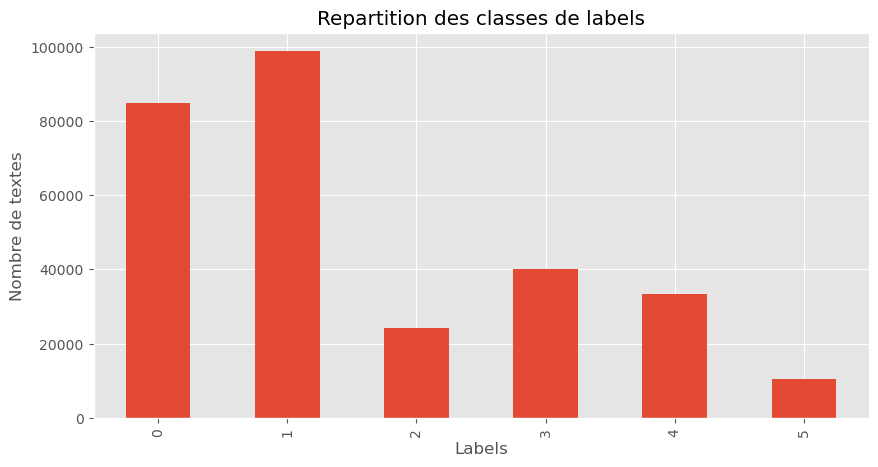

In [9]:
ax=train["label"].value_counts().sort_index().plot(
    kind='bar',title="Repartition des classes de labels",figsize=(10,5))
ax.set_xlabel("Labels")
ax.set_ylabel("Nombre de textes")
plt.show()

On observe un déséquilibre marqué entre les classes : la classe 1 (joie) est largement majoritaire avec près de 100 000 textes, tandis que la classe 5 (surprise) est très minoritaire.
Ce déséquilibre risque de biaiser l’apprentissage du modèle, qui pourrait avoir tendance à prédire la classe majoritaire (joie) au détriment des classes plus rares comme la surprise.

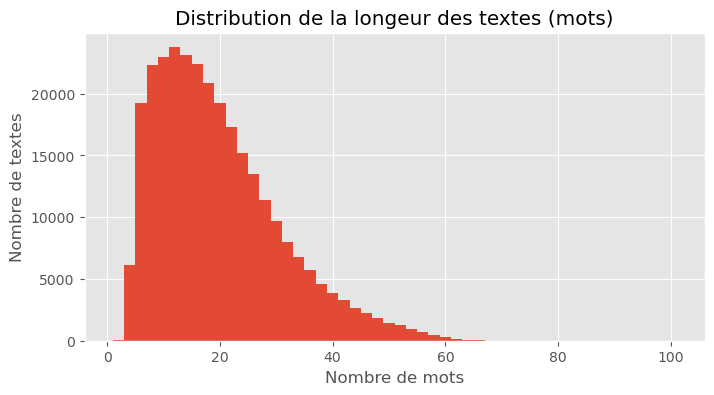

In [10]:
train["text_length"]=train["text"].apply(lambda x: len(str(x).split()))
train["text_length"].hist(bins=50,figsize=(8,4))
plt.title("Distribution de la longeur des textes (mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de textes")
plt.show()

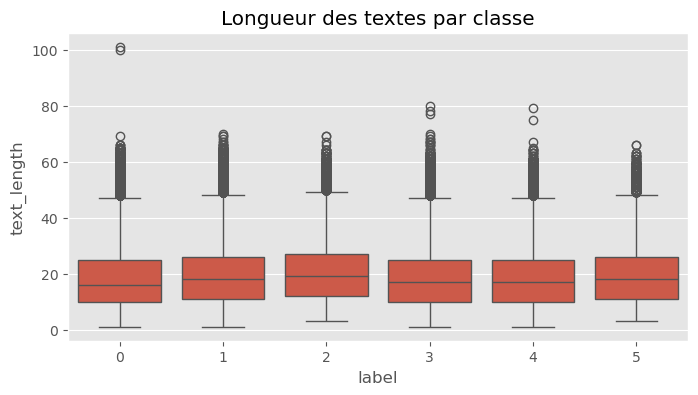

In [11]:
plt.figure(figsize=(8,4))
sns.boxplot(x="label",y="text_length",data=train)
plt.title("Longueur des textes par classe")
plt.show()

La repartition des textes est presque là même dans chaque classe 

In [12]:
def top_words(texts,n=10):
    words=" ".join(texts).lower().split()
    return Counter(words).most_common(n)

for label in sorted(train["label"].unique()):
    print(f"Classe {label} :")
    print(top_words(train[train["label"]==label]["text"],15))
    print("-"*50)

Classe 0 :
[('i', 138914), ('feel', 58953), ('and', 49412), ('to', 42461), ('the', 39329), ('a', 30415), ('feeling', 28628), ('of', 24583), ('that', 24320), ('my', 22192), ('in', 16424), ('it', 16253), ('like', 15401), ('so', 14409), ('for', 14318)]
--------------------------------------------------
Classe 1 :
[('i', 157617), ('feel', 71745), ('and', 60763), ('to', 59664), ('the', 55589), ('a', 39565), ('that', 34267), ('of', 31025), ('feeling', 28779), ('my', 25972), ('in', 22234), ('it', 20777), ('like', 17609), ('have', 16252), ('is', 15856)]
--------------------------------------------------
Classe 2 :
[('i', 39738), ('feel', 17175), ('and', 15681), ('the', 15213), ('to', 14651), ('a', 10963), ('of', 9414), ('that', 8296), ('my', 7939), ('feeling', 7198), ('in', 5601), ('like', 5301), ('it', 5047), ('for', 4714), ('me', 4136)]
--------------------------------------------------
Classe 3 :
[('i', 65371), ('feel', 26331), ('and', 23585), ('to', 21163), ('the', 19446), ('a', 15071), ('

La majorité des mots ne permettent pas de definir le sentiment car souvent des mots neutres en emotions.

In [13]:
print("Nombres de doublons : ", train.duplicated(subset="text").sum())
short_texts=train[train["text_length"]<=2]
print(f"Textes très courts : :{len(short_texts)}")
print(short_texts.head())

Nombres de doublons :  11197
Textes très courts : :77
                     text  label  text_length
190092  never experienced      4            2
235067         in college      4            2
332509            one day      0            2
138410       doesnt apply      3            2
197794        getting ill      4            2


In [14]:
#Focus sur les doublons
train['is_duplicate'] = train.duplicated(subset='text', keep=False)
duplicates=train[train["is_duplicate"]]
duplicates.head(5)

,text,label,text_length,is_duplicate
304620,i feel blessed and i give all the honor to god,2,11,True
291574,i feel a trace of disgrace for the gracious ma...,1,13,True
406848,i feel like my meds arent working correctly an...,4,12,True
91814,i cant do anything except for feeling more str...,3,9,True
300971,i must admit i feel a bit stressed as i think ...,0,16,True


On retrouve ici toutes les textes doublons quelques soit le label c'est-à-dire qu'un texte peut apparaître en doublon dans un même label ou dans un label différent

Text(0, 0.5, 'Nombre de doublons')

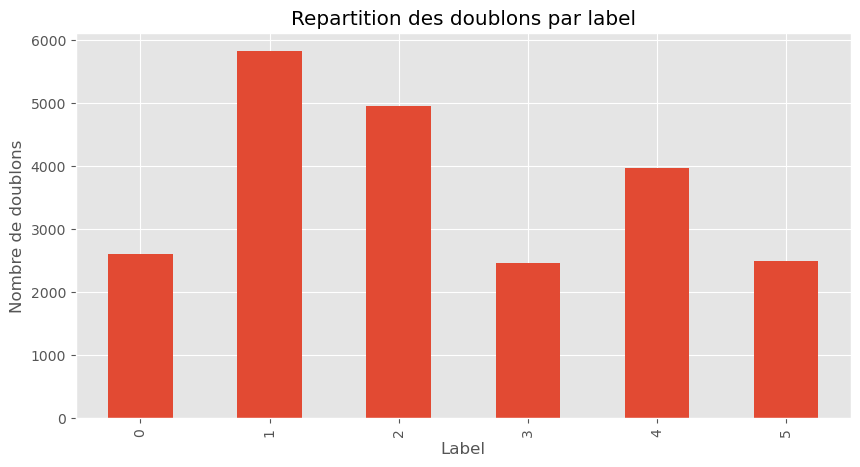

In [15]:
ax=duplicates["label"].value_counts().sort_index().plot(
    kind="bar",title="Repartition des doublons par label",figsize=(10,5))
ax.set_xlabel("Label")
ax.set_ylabel("Nombre de doublons")


Nous allons procéder en deux étapes :
- 1) Déterminer et supprimer le cas écheant les doublons présents dans un même label
- 2) Analyser les doublons présents dans des labels très différents.

Pour rappel les émotions sont classés de la façon suivante :
- tristesse (0), 
- joie (1), 
- amour (2), 
- colère (3), 
- peur (4) et 
- surprise (5).

##### 1)Pareils doublons

In [37]:
#supprimer les doublons où le text et le label sont identiques
train_clean = train.drop_duplicates(subset=["text", "label"])

print("Avant :", len(train))
print("Après suppression des doublons exacts :", len(train_clean))

Avant : 291766
Après suppression des doublons exacts : 291405


##### 2) Maintenant analysons les doublons de labels différents

In [38]:
#liste d'émotions contradictoires
contradictions = [
    [0, 1],  # tristesse + joie
    [0, 2],  # tristesse + amour
    [1, 3],  # joie + colère
    [1, 4]   # joie + peur
]

# Regrouper tous les labels associés à chaque texte
labels_per_text = train_clean.groupby("text")["label"].unique()
# Garder seulement les textes qui ont plusieurs labels différents
ambiguous_texts = labels_per_text[labels_per_text.apply(len) > 1]

# indices_per_text : liste des indices originaux par texte parce que chaque texte est un indice unique on va le recuperer après
indices_per_text = train_clean.groupby("text").apply(lambda x: x.index.tolist())

#Fonction pour comparer les emotions à un referentiel de contradictions
def label_contradiction(label,contradictions):
    for ref in contradictions:
        if sorted(ref)==sorted(label):
            return True
    else : return False
        
#on applique la fonction
contradictory_texts=labels_per_text[labels_per_text.apply(lambda x:label_contradiction(x,contradictions))]
#on recupère les index des contradictions 
contradictory_indices=indices_per_text.loc[contradictory_texts.index].explode().tolist()
train_clean = train_clean.drop(index=contradictory_indices)



/tmp/ipykernel_12599/3305276584.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices_per_text = train_clean.groupby("text").apply(lambda x: x.index.tolist())


#### Traitement des données textuelles

In [39]:
def traitement_texte(text):
    # Convertir le texte en minuscules
    text=text.lower()
    #Supprimer la ponctuation
    text = text.translate(str.maketrans("", "", string.punctuation)) #equivalent de "".join([ch for ch in text if ch not in string.punctuation])
    #tokenization
    #tokens=word_tokenize(text,language="english")
    #Suppression des stopwords
    #stop_words=set(stopwords.words("english"))
    #tokens_clean=[word for word in tokens if word not in stop_words]
    #Lemmatisation (reduction à la forme de base)
    #lemmatizer=WordNetLemmatizer()
    #tokens_lemmatized=[lemmatizer.lemmatize(word) for word in tokens_clean]
    return text
    

In [19]:
train_clean

,text,label,text_length,is_duplicate
200603,i continued to feel strong for a few miles aft...,1,24,False
34804,i cant stop saying that im like feeling so ecs...,1,10,False
221318,i feel so breatheless and helpless,0,6,False
304620,i feel blessed and i give all the honor to god,2,11,True
82905,ill be feeling bouncy for monday and work again,1,9,False
...,...,...,...,...
280360,i was hungry and tired and could feel myself g...,3,11,False
70499,i was feeling terrible but of course she did f...,0,10,False
380649,i had hidden in my room all day feeling intimi...,4,21,False
403684,ive tried being against it and it makes me fee...,0,12,False


In [40]:
train_clean["text_clean"]=train_clean["text"].apply(traitement_texte)

In [ ]:
train_clean["text_clean"]

200603    i continued to feel strong for a few miles aft...
34804     i cant stop saying that im like feeling so ecs...
221318                   i feel so breatheless and helpless
304620       i feel blessed and i give all the honor to god
82905       ill be feeling bouncy for monday and work again
                                ...                        
280360    i was hungry and tired and could feel myself g...
70499     i was feeling terrible but of course she did f...
380649    i had hidden in my room all day feeling intimi...
403684    ive tried being against it and it makes me fee...
76891     i am angry sad depressed and feel like damaged...
Name: text_clean, Length: 291393, dtype: object

In [41]:
train_clean=train_clean.drop(["text_length","is_duplicate","text"],axis=1)

In [42]:
X_train,y_train=train_clean.drop(["label"],axis=1),train_clean["label"]

In [25]:
X_train

,text_clean
200603,i continued to feel strong for a few miles aft...
34804,i cant stop saying that im like feeling so ecs...
221318,i feel so breatheless and helpless
304620,i feel blessed and i give all the honor to god
82905,ill be feeling bouncy for monday and work again
...,...
280360,i was hungry and tired and could feel myself g...
70499,i was feeling terrible but of course she did f...
380649,i had hidden in my room all day feeling intimi...
403684,ive tried being against it and it makes me fee...


#### Modélisation

In [26]:
#Vectorisation TF-IDF
vectorizer=TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    stop_words="english",
    sublinear_tf=True,
    norm="l2")#max_features pour le nombre de mots les plus fréquents dans le vocabulaire
X_train_vec=vectorizer.fit_transform(X_train["text_clean"])

In [27]:
X_train.shape

(291393, 1)

Accuracy entrainement : 0.9266180038641971
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     84734
           1       0.98      0.90      0.94     98579
           2       0.75      0.99      0.85     24162
           3       0.92      0.96      0.94     40073
           4       0.91      0.89      0.90     33371
           5       0.71      0.99      0.83     10474

    accuracy                           0.93    291393
   macro avg       0.88      0.94      0.90    291393
weighted avg       0.94      0.93      0.93    291393



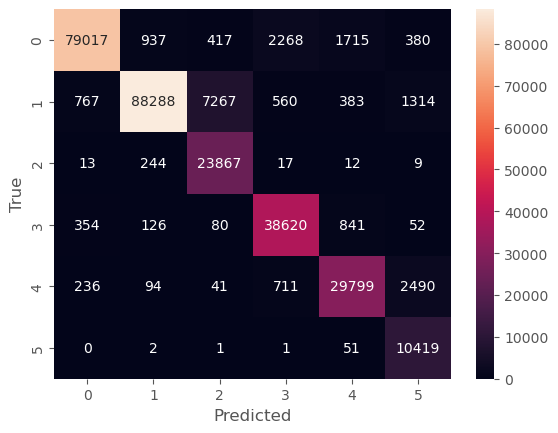

In [28]:
#premier modèle : regression logistique
model_reg=LogisticRegression(
    max_iter=1000,
    penalty="l2",
    class_weight="balanced",#pour le cas de classes déséquilibrées
    n_jobs=-1
)

model_reg.fit(X_train_vec,y_train)
y_pred_reg=model_reg.predict(X_train_vec)
#evaluation
print("Accuracy entrainement :", accuracy_score(y_train,y_pred_reg))
print(classification_report(y_train,y_pred_reg))
cm = confusion_matrix(y_train, y_pred_reg)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

On remarque que seuls les labels 2 et 5 présentent des précisions inférieures à 0,9, contrairement aux autres classes dont la précision est supérieure à 0,9.
Ainsi, seulement 75 % et 71 % des éléments des classes 2 et 5 ont été correctement identifiés parmi ceux que le modèle avait prédits comme appartenant à ces classes.

Les recalls de toutes les classes sont supérieurs à 0,9. On peut donc dire que le modèle a correctement retrouvé plus de 90 % des vrais positifs de chaque classe parmi ceux qui en faisaient réellement partie.

Les F1-Score de toutes les classes sont quand à eux supérieurs à 0.8, nous indiquant que le modèle équilibre bien précision et rappel: la majorité des prédictions positives sont correctes ce qui signifie que le modèle se trompe rarement en attribuant une émotion à tord (précision) ensuite le modèle détecte la majorité des vrais exemples pour chaque classes limitant les faux positifs (recall).
Concrètement pour chaque classe d'émotion, cela signifie que le modèle identifie correctement plus de 80% des tweets correspondants tout en limant les erreurs de predicitions 
Même pour les classes les plus rares, le modèle reste performant, ce qui montre sa robustesse face aux déséquilibres du dataset.

En résumé, un F1-score supérieur à 80 % est un indicateur fort que notre modèle capture efficacement le signal émotionnel présent dans les tweets, tout en maintenant un bon équilibre entre précision et rappel.

Accuracy entrainement : 0.9092152299608934
              precision    recall  f1-score   support

           0       0.97      0.92      0.95     36356
           1       0.97      0.89      0.93     42320
           2       0.74      0.96      0.84     10366
           3       0.89      0.94      0.91     17195
           4       0.87      0.85      0.86     14314
           5       0.67      0.93      0.78      4492

    accuracy                           0.91    125043
   macro avg       0.85      0.92      0.88    125043
weighted avg       0.92      0.91      0.91    125043



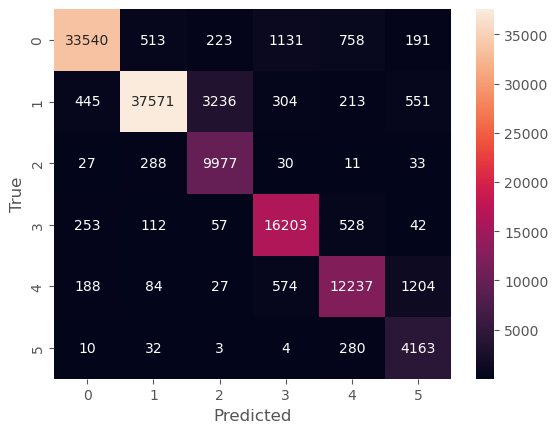

In [29]:
X_test_vec=vectorizer.transform(X_test["text"])
y_pred_test_reg=model_reg.predict(X_test_vec)
print("Accuracy entrainement :", accuracy_score(y_test,y_pred_test_reg))
print(classification_report(y_test,y_pred_test_reg))
cm = confusion_matrix(y_test, y_pred_test_reg)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

##### Deuxième modèle : LSTM


In [30]:
X_train.head()

,text_clean
200603,i continued to feel strong for a few miles aft...
34804,i cant stop saying that im like feeling so ecs...
221318,i feel so breatheless and helpless
304620,i feel blessed and i give all the honor to god
82905,ill be feeling bouncy for monday and work again


In [ ]:
#Tokenization + padding pour LSTM
tokenizer=Tokenizer(num_words=20000,oov_token="<OOV>")#OOV(out-of-vocab)token special pour les mots hors vocabulaire Quand un mot inconnu est rencontré dans texts_to_sequences, il sera remplacé par l’indice du oov_token. Utile pour gérer mots rares / nouveaux mots.
tokenizer.fit_on_texts(X_train["text_clean"])#analyser tous les textes pour compter la frequence de chaque mot, construire tokenizer.word_counts, faire mapping mot
X_train_lstm=tokenizer.texts_to_sequences(X_train["text_clean"])#transformer chaque texte chaîne en liste d'entiers (sequence)
X_train_lstm=pad_sequences(X_train_lstm,maxlen=50,padding="post")#maxlen : toutes les séquences à la même longueur (les séquences plus longues seront tronquées), padding ="post" on ajoute 0 à la fin des séquences courtes

#Gestion du désquilibrage des classes
weights=class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)#calcule un poids par classe inversement proportionnel à sa fréquence 
class_weights=dict(enumerate(weights))#transforme en dictionnaire {0: w0, 1: w1, ...} format attendu par model.fit(class_weight=...).

#Construction du modèle
model_lstm=Sequential([
    Embedding(input_dim=20000,output_dim=64, input_length=50),#dimension 64 5000 taille du vocabulaire, input_length)50 longueur sequence d'entrée
    LSTM(64,dropout=0.3,recurrent_dropout=0.3),#
    Dense(32,activation="relu"),
    Dropout(0.3),#on met à 0 aléatoirement 30% des neurones pour reduire l'overfitting
    Dense(6, activation="softmax")
])
#Compilation
model_lstm.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

#Entraînement
history=model_lstm.fit(X_train_lstm,y_train,
                       validation_split=0.2,epochs=6,
                       batch_size=32,class_weight=class_weights,verbose=1)

/home/coffi/miniconda3/envs/mon_env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
7285/7285 ━━━━━━━━━━━━━━━━━━━━ 561s 76ms/step - accuracy: 0.1476 - loss: 1.7917 - val_accuracy: 0.0835 - val_loss: 1.7986
Epoch 2/10
7285/7285 ━━━━━━━━━━━━━━━━━━━━ 561s 77ms/step - accuracy: 0.1304 - loss: 1.7914 - val_accuracy: 0.2870 - val_loss: 1.7904
Epoch 3/10
7285/7285 ━━━━━━━━━━━━━━━━━━━━ 484s 66ms/step - accuracy: 0.1788 - loss: 1.7901 - val_accuracy: 0.1152 - val_loss: 1.7950
Epoch 4/10
7285/7285 ━━━━━━━━━━━━━━━━━━━━ 576s 79ms/step - accuracy: 0.3675 - loss: 1.3095 - val_accuracy: 0.9286 - val_loss: 0.1995
Epoch 5/10
7285/7285 ━━━━━━━━━━━━━━━━━━━━ 8374s 1s/step - accuracy: 0.9287 - loss: 0.1671 - val_accuracy: 0.9388 - val_loss: 0.1242
Epoch 6/10
7285/7285 ━━━━━━━━━━━━━━━━━━━━ 469s 64ms/step - accuracy: 0.9340 - loss: 0.1325 - val_accuracy: 0.9394 - val_loss: 0.1285
Epoch 7/10
7285/7285 ━━━━━━━━━━━━━━━━━━━━ 471s 65ms/step - accuracy: 0.9369 - loss: 0.1215 - val_accuracy: 0.9389 - val_loss: 0.1234
Epoch 8/10
7285/7285 ━━━━━━━━━━━━━━━━━━━━ 481s 66ms/step - accuracy: 0

3908/3908 ━━━━━━━━━━━━━━━━━━━━ 73s 18ms/step
Accuracy entrainement : 0.937757411450461
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     36356
           1       1.00      0.91      0.95     42320
           2       0.77      0.99      0.87     10366
           3       0.93      0.95      0.94     17195
           4       0.90      0.90      0.90     14314
           5       0.72      1.00      0.84      4492

    accuracy                           0.94    125043
   macro avg       0.89      0.95      0.91    125043
weighted avg       0.95      0.94      0.94    125043



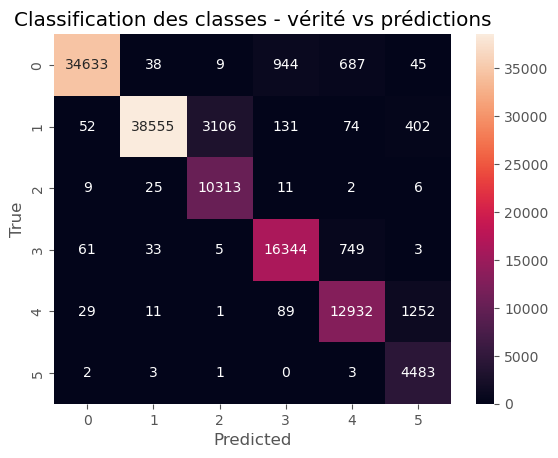

In [36]:
#Evaluation du modèle
X_test_lstm = tokenizer.texts_to_sequences(X_test["text"])
X_test_lstm = pad_sequences(X_test_lstm, maxlen=50, padding="post")
y_pred_test_lstm = np.argmax(model_lstm.predict(X_test_lstm), axis=1)
print("Accuracy entrainement :", accuracy_score(y_test,y_pred_test_lstm))
print(classification_report(y_test,y_pred_test_lstm))
cm = confusion_matrix(y_test, y_pred_test_lstm)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Classification des classes - vérité vs prédictions")
plt.show()
